## OSN zarr format 

In [1]:
import dask.array as dsa
import fsspec
import numpy as np
import pandas as pd
from contextlib import contextmanager
import pandas as pd
import intake
import time
#import seaborn as sns
import dask
from matplotlib import pyplot as plt

In [2]:
import s3fs
import xarray as xr
import dask
import fsspec
import zarr
import dask.array as dsa
import pandas as pd

endpoint_url = "https://mghp.osn.xsede.org"
bucket = 'cnh-bucket-1'


In [3]:
fs = s3fs.S3FileSystem(anon=True,
                       client_kwargs={'endpoint_url': endpoint_url})
listing = fs.listdir(bucket)
listing

[{'Key': 'cnh-bucket-1/DYAMOND',
  'Size': 0,
  'StorageClass': 'DIRECTORY',
  'type': 'directory',
  'size': 0,
  'name': 'cnh-bucket-1/DYAMOND'},
 {'Key': 'cnh-bucket-1/llc4320_grid',
  'Size': 0,
  'StorageClass': 'DIRECTORY',
  'type': 'directory',
  'size': 0,
  'name': 'cnh-bucket-1/llc4320_grid'},
 {'Key': 'cnh-bucket-1/llc4320_tests',
  'Size': 0,
  'StorageClass': 'DIRECTORY',
  'type': 'directory',
  'size': 0,
  'name': 'cnh-bucket-1/llc4320_tests'},
 {'Key': 'cnh-bucket-1/llc4320_zarr',
  'Size': 0,
  'StorageClass': 'DIRECTORY',
  'type': 'directory',
  'size': 0,
  'name': 'cnh-bucket-1/llc4320_zarr'},
 {'Key': 'cnh-bucket-1/llc_masks',
  'Size': 0,
  'StorageClass': 'DIRECTORY',
  'type': 'directory',
  'size': 0,
  'name': 'cnh-bucket-1/llc_masks'}]

In [27]:
mapper_osn = fs.get_mapper('cnh-bucket-1/llc4320_zarr')
zgroup_osn = zarr.open_consolidated(mapper_osn)
print(zgroup_osn.info)

Name             : /
Type             : zarr.hierarchy.Group
Read-only        : False
Store type       : zarr.storage.ConsolidatedMetadataStore
Chunk store type : fsspec.mapping.FSMap
No. members      : 5
No. arrays       : 5
No. groups       : 0
Arrays           : Eta, face, i, j, time



In [28]:
array_osn = zgroup_osn['Eta']

In [31]:
array_dask_osn = dask.array.from_zarr(array_osn)

CPU times: user 4.43 s, sys: 1.8 s, total: 6.23 s
Wall time: 20.1 s


In [32]:
array_dask_osn

,Array,Chunk
Bytes,8.76 TB,74.65 MB
Shape,"(9030, 13, 4320, 4320)","(1, 1, 4320, 4320)"
Count,117391 Tasks,117390 Chunks
Type,>f4,numpy.ndarray


## This is where I manually change the data for small v/s large chunk sizes. 

In [8]:
# For smaller chunk sizes I use a data set of about 75 GB with a 1000 chunks. Good for reading with upto 20 workers
data = array_dask_osn[:1000,0,:]
data

dask.array<getitem, shape=(1000, 4320, 4320), dtype=>f4, chunksize=(1, 4320, 4320), chunktype=numpy.ndarray>

In [9]:
# For large chunk sizes I use a data set of about 675 GB with 9030 chunks. Good for reading with workers more than 20
data = array_dask_osn[:,0,:]
data

dask.array<getitem, shape=(9030, 4320, 4320), dtype=>f4, chunksize=(1, 4320, 4320), chunktype=numpy.ndarray>

In [35]:
class DevNullStore:

    def __init__(self):
        pass

    def __setitem__(*args, **kwargs):
        pass

In [36]:
null_store = DevNullStore()
# this line produces no error but actually does nothing
null_store['foo'] = 'bar'

In [60]:
from dask_gateway import Gateway
from dask.distributed import Client

gateway = Gateway()
cluster = gateway.new_cluster()
cluster

In [61]:
client = Client(cluster)
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-prod-dask-gateway.prod:80/prod.49ed01554bb1439daa9aeded90a4724d Dashboard: /services/dask-gateway/clusters/prod.49ed01554bb1439daa9aeded90a4724d/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [62]:
class DiagnosticTimer:
    def __init__(self):
        self.diagnostics = []

    @contextmanager
    def time(self, **kwargs):
        tic = time.time()
        yield
        toc = time.time()
        kwargs["runtime"] = toc - tic
        self.diagnostics.append(kwargs)

    def dataframe(self):
        return pd.DataFrame(self.diagnostics)

diag_timer = DiagnosticTimer()


In [63]:
chunksize = np.prod(data.chunksize) * data.dtype.itemsize
chunksize

74649600

In [64]:
def total_nthreads():
    return sum([v for v in client.nthreads().values()])

def total_ncores():
    return sum([v for v in client.ncores().values()])

def total_workers():
    return len(client.ncores())

In [65]:
diag_kwargs = dict(nbytes=data.nbytes, chunksize=chunksize,
                   cloud='osn', format='zarr')

#1,1,2,2,4,4,6,7,8,9,15,16,20,25,30,35,40,45,50,55,60,70
for nworkers in [1,2,4,6,7,8,9,15,16]:
    cluster.scale(nworkers)
    time.sleep(10)
    client.wait_for_workers(nworkers)
    print(nworkers)
    with diag_timer.time(nthreads=total_nthreads(),
                         ncores=total_ncores(),
                         nworkers=total_workers(),
                         **diag_kwargs):

        future = dsa.store(data, null_store, lock=False, compute=False)
        dask.compute(future, retries=5)



1
2
4
6
7
8
9
15
16


In [66]:
client.close()
cluster.close()

In [67]:
df = diag_timer.dataframe()
df


,nthreads,ncores,nworkers,nbytes,chunksize,cloud,format,runtime
0,2,2,1,74649600000,74649600,osn,zarr,44.555869
1,4,4,2,74649600000,74649600,osn,zarr,23.563483
2,8,8,4,74649600000,74649600,osn,zarr,13.974932
3,12,12,6,74649600000,74649600,osn,zarr,13.693488
4,14,14,7,74649600000,74649600,osn,zarr,7.671741
5,16,16,8,74649600000,74649600,osn,zarr,6.823653
6,18,18,9,74649600000,74649600,osn,zarr,6.854867
7,30,30,15,74649600000,74649600,osn,zarr,5.586237
8,32,32,16,74649600000,74649600,osn,zarr,4.224936


<AxesSubplot:xlabel='ncores'>

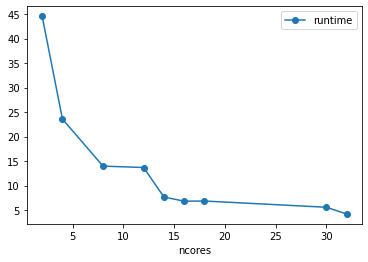

In [68]:
df.plot(x='ncores', y='runtime', marker='o')

<AxesSubplot:xlabel='ncores'>

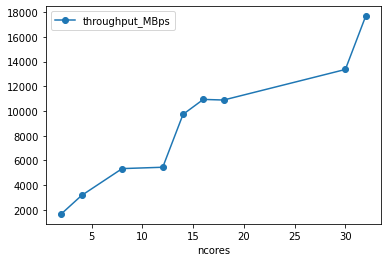

In [69]:
df['throughput_MBps'] = df.nbytes / 1e6 / df['runtime']
df.plot(x='ncores', y='throughput_MBps', marker='o')

<AxesSubplot:xlabel='nthreads'>

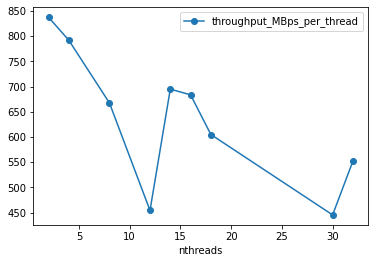

In [70]:
df['throughput_MBps_per_thread'] = df.throughput_MBps / df.nthreads
df.plot(x='nthreads', y='throughput_MBps_per_thread', marker='o')



In [71]:
df.to_csv('osn_zarr_test-5_us_central.csv')

In [72]:
df

,nthreads,ncores,nworkers,nbytes,chunksize,cloud,format,runtime,throughput_MBps,throughput_MBps_per_thread
0,2,2,1,74649600000,74649600,osn,zarr,44.555869,1675.415659,837.707830
1,4,4,2,74649600000,74649600,osn,zarr,23.563483,3168.020555,792.005139
2,8,8,4,74649600000,74649600,osn,zarr,13.974932,5341.678960,667.709870
3,12,12,6,74649600000,74649600,osn,zarr,13.693488,5451.467292,454.288941
4,14,14,7,74649600000,74649600,osn,zarr,7.671741,9730.464341,695.033167
5,16,16,8,74649600000,74649600,osn,zarr,6.823653,10939.829471,683.739342
6,18,18,9,74649600000,74649600,osn,zarr,6.854867,10890.013622,605.000757
7,30,30,15,74649600000,74649600,osn,zarr,5.586237,13363.128098,445.437603
8,32,32,16,74649600000,74649600,osn,zarr,4.224936,17668.811989,552.150375
